# Machine Learning Ensemble Analysis

In this notebook, we will employ **Machine Learning** methods for a simple analysis of the structural variations (flexibility) in a protein. It is a straightforward illustration of how differential geometry can used to classify the protein backbone plasticity. For more information about the use of differential geometry for such purpose, please refer to:

<ol>
    <li>Marinho da Silva Neto A, Reghim Silva S, Vendruscolo M, Camilloni C, Montalvão R: A Superposition Free Method for Protein Conformational Ensemble Analyses and Local Clustering Based on a Differential Geometry Representation of Backbone. Proteins: Structure, Function, and Bioinformatics. 2018, 87(4):302-312</li>
</ol>

In [1]:
import dill
import warnings

import numpy as np
import pandas as pd
import nglview as nv
import melodia_py as mel
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from ipywidgets import Box

from Bio.PDB import PDBParser, PDBIO
from Bio.PDB.PDBExceptions import PDBConstructionWarning

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

warnings.filterwarnings("ignore", category=PDBConstructionWarning)

## Load protein structure

First we load the structure for the *"Williams-Beuren syndrome related methyltransferase WBSCR27 in apo-form"*, and we use **Melodia** to compute the differential geometry descriptors for all its states.

In [2]:
parser = PDBParser()
structure = parser.get_structure('7qcc', '7qcc.pdb')

<img src="7qcc.png" width="800">

In [3]:
%%time
geo_dict = mel.geometry_dict_from_structure(structure)
geo_dict

CPU times: user 8.26 s, sys: 3.22 ms, total: 8.26 s
Wall time: 8.25 s


{'0:A': <melodia_py.geometryparser.GeometryParser at 0x758fad26af20>,
 '1:A': <melodia_py.geometryparser.GeometryParser at 0x758fad26b1a0>,
 '2:A': <melodia_py.geometryparser.GeometryParser at 0x75903dbfdc60>,
 '3:A': <melodia_py.geometryparser.GeometryParser at 0x758fb2584450>,
 '4:A': <melodia_py.geometryparser.GeometryParser at 0x758fb2584540>,
 '5:A': <melodia_py.geometryparser.GeometryParser at 0x758fb2584590>,
 '6:A': <melodia_py.geometryparser.GeometryParser at 0x758fb25845e0>,
 '7:A': <melodia_py.geometryparser.GeometryParser at 0x758fb2584630>,
 '8:A': <melodia_py.geometryparser.GeometryParser at 0x758fb25844a0>,
 '9:A': <melodia_py.geometryparser.GeometryParser at 0x758fb2584360>,
 '10:A': <melodia_py.geometryparser.GeometryParser at 0x758fb25844f0>,
 '11:A': <melodia_py.geometryparser.GeometryParser at 0x758fb25847c0>,
 '12:A': <melodia_py.geometryparser.GeometryParser at 0x758fb2584770>,
 '13:A': <melodia_py.geometryparser.GeometryParser at 0x758fb2584810>,
 '14:A': <melodi

In [4]:
geo_dict['0:A'].residues[0]

ResidueGeometry(name='GLY', chain='A', res_num=0, res_order=1, curvature=0.655489870551698, torsion=np.float64(-0.01174766275556318), arc_len=8.285926262962365, writhing=0.044976665370279174, phi=0.0, psi=-126.73679898842404, res_ann={}, custom=0.0)

## Compute differential geometry statistics

A very straightforward way to analyse protein flexibility is to compute the standard deviation of the curvature and torsion descriptors. This approach is direct and naive, but it is very useful for an initial educational purpose. 

In [5]:
# Create a list of all models
models = list(geo_dict.keys())

# Select the 1st model a the reference
model_ref = models[0]

# Create a list of residues from the reference model.
residues = geo_dict[model_ref].residues.keys()

# Create storage for the residues' info
name = []
order = []

# Curvature (k) and torsion (t) std storage
kstds = []
tstds = []

# Compute and store the standard deviation for each residue
data = {}
for residue in residues:
    name.append(geo_dict[model_ref].residues[residue].name)
    order.append(geo_dict[model_ref].residues[residue].res_order)
    
    curvatures = np.array([geo_dict[model].residues[residue].curvature for model in models])
    torsions = np.array([geo_dict[model].residues[residue].torsion for model in models])
      
    kstds.append(np.std(curvatures))
    tstds.append(np.std(torsions))
    
    data[residue] = (np.std(curvatures), np.std(torsions))

In [6]:
# For each residue, use one of the standard deviation as a custom descriptor
for residue in residues:
    kstd, tstd = data[residue]
    for model in models:
        geo_dict[model].residues[residue].custom = kstd
        #geo_dict[model].residues[residue].custom = tstd

# Output the protein using the custom descriptor as its b-factor
mel.bfactor_from_geo(structure=structure, attribute='custom', geo=geo_dict)

io = PDBIO()
io.set_structure(structure)
io.save('7qcc_geo.pdb')

In [7]:
# Open and display the new protein file using the b-factor as color
with open('7qcc_geo.pdb') as f:
    view = nv.show_file(f, ext='pdb', default_representation=False)
    view.add_tube('protein', color_scheme='bfactor') 
    view.center()
    view.layout.width = '100%'
    view.layout.height = '100%'

width = 800
height = 600
box = Box([view])
box.layout.width = f'{width}px'
box.layout.height = f'{height}px'

box

Box(children=(NGLWidget(layout=Layout(height='100%', width='100%')),), layout=Layout(height='600px', width='80…

In [8]:
# It is simple to create a Pandas DataFrame using the stored data
df_dict = {'name': name, 'order': order, 'kstd': kstds, 'tstd': tstds}

df = pd.DataFrame(df_dict)
df

,name,order,kstd,tstd
0,GLY,1,0.250258,0.066721
1,ALA,2,0.250258,0.066721
2,MET,3,0.186630,0.027030
3,ALA,4,0.073399,0.013248
4,GLN,5,0.172497,0.030119
...,...,...,...,...
235,LYS,236,0.012970,0.018159
236,GLN,237,0.020744,0.017485
237,GLU,238,0.011209,0.048499
238,THR,239,0.050569,2.363814


## Naive residue clustering

In [9]:
# For a simple clustering algorithm, we can select just the curvature variation as a good indicator.
df_clust = df.copy()
df_clust.drop(['name', 'tstd'], axis=1, inplace=True)
df_clust

,order,kstd
0,1,0.250258
1,2,0.250258
2,3,0.186630
3,4,0.073399
4,5,0.172497
...,...,...
235,236,0.012970
236,237,0.020744
237,238,0.011209
238,239,0.050569


In [10]:
# By selecting the residues with the variation above a threshold, we can see the regions of high plasticity in the
# protein. 
threshold = 0.1
clabels = [5 if x > threshold else 0 for x in list(df_clust['kstd'])]

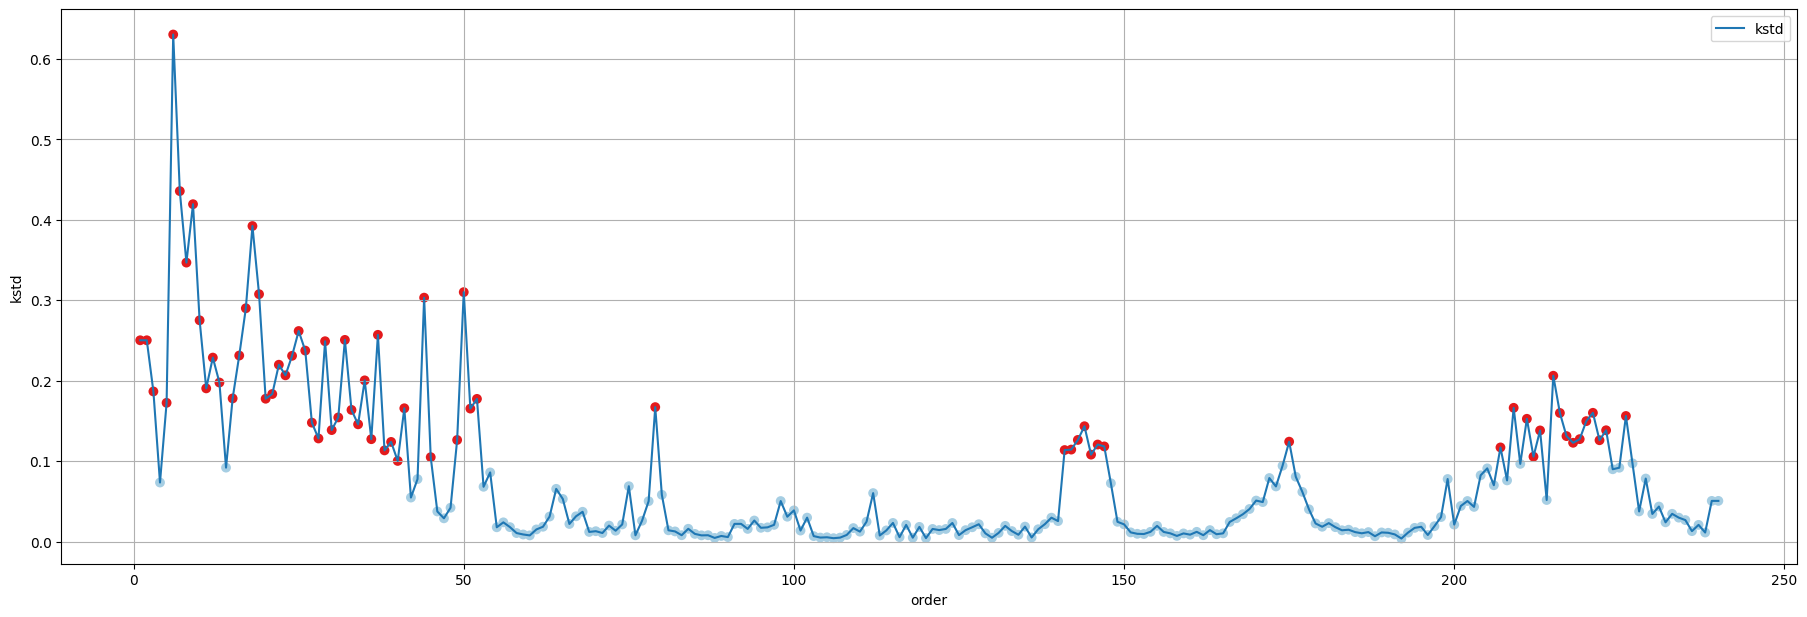

In [11]:
color_palette = sns.color_palette('Paired', 6)
cluster_colors = [color_palette[x] for x in clabels]

ax = df_clust.plot.scatter(x='order', y='kstd', s=50, linewidth=0, c=cluster_colors, figsize=(6.4*3.5, 4.8*1.5));
df_clust.plot(x='order', y='kstd', figsize=(6.4*3.5, 4.8*1.5), ax=ax)
plt.grid()

## Machine Learning clustering

In this section, we will show how a clustering algorithm can be used to straightforwardly cluster the protein states. Clustering the geometry of intricate geometric states is a very complex undertaking. An advanced treatment of this process is discussed in reference 1.

In [12]:
# Read the PDB file and compute the differential geometry
df = mel.geometry_from_structure_file('7qcc.pdb')
df

,id,model,code,chain,order,name,curvature,torsion,arc_length,writhing,phi,psi
0,0,0,7QCC,A,1,GLY,0.655490,-0.011748,8.285926,0.044977,0.000000,-126.736799
1,1,0,7QCC,A,2,ALA,0.655490,-0.011748,7.835393,0.044977,-99.991683,125.013722
2,2,0,7QCC,A,3,MET,0.911512,0.062481,7.996808,0.044977,-69.891987,-40.057212
3,3,0,7QCC,A,4,ALA,0.475448,0.091996,8.355257,0.211264,-60.847249,-50.006645
4,4,0,7QCC,A,5,GLN,0.551142,0.110172,8.592230,0.161675,-60.027246,-49.318141
...,...,...,...,...,...,...,...,...,...,...,...,...
4795,235,19,7QCC,A,236,LYS,0.295639,-0.106322,8.385317,-0.031315,-69.700516,135.767588
4796,236,19,7QCC,A,237,GLN,0.347380,0.118185,8.308139,0.048927,70.401664,74.143779
4797,237,19,7QCC,A,238,GLU,0.107933,0.575681,7.977047,0.007710,-153.910984,150.291781
4798,238,19,7QCC,A,239,THR,0.050548,-3.792121,8.153073,0.007710,-114.872856,0.000000


**The next step is to scale the curvature and torsion values for clustering. We select the region between residues 140 and 146 (remember that Python indexing starts at zero).**

In [13]:
# Define the autoscaler from scikit-learn
autoscaler = StandardScaler()

# Define features for scaling
features = ['curvature', 'torsion']

# Region for clustering
ini = 140
end = 146

# Scale the DataFrame
dfsd = df[(df.order >= ini) & (df.order <= end)].copy()
dfsd[features] = autoscaler.fit_transform(dfsd[features])
dfsd.drop(['id', 'code', 'chain', 'name', 'arc_length', 'writhing', 'phi', 'psi'], axis=1, inplace=True)
dfsd

,model,order,curvature,torsion
139,0,140,-1.165481,-1.438501
140,0,141,-0.491590,0.339768
141,0,142,0.867862,1.320843
142,0,143,0.834302,0.618573
143,0,144,-0.142229,0.511686
...,...,...,...,...
4701,19,142,1.113361,1.173884
4702,19,143,0.485915,0.783763
4703,19,144,0.232712,0.527698
4704,19,145,0.293450,-1.333673


**We pivot the table to put the models in the rows and the residue's differential geometry in the columns. This arrangement makes extracting the descriptor vector for each model straightforward.**

In [14]:
dfc = dfsd.pivot_table(index='model', columns='order', values=['curvature', 'torsion'])
dfc

curvature                                                              \
order       140       141       142       143       144       145       146   
model                                                                         
0     -1.165481 -0.491590  0.867862  0.834302 -0.142229  0.394621 -0.254580   
1     -0.982237 -0.616236  1.711427 -0.531277  0.861210  0.318782 -0.705263   
2     -1.428345  0.939863  0.338455  1.077983 -0.055714  0.058411  0.392669   
3     -1.479628  1.368781  0.201649  0.471303  1.033980 -1.282546  0.684010   
4     -1.408713  0.780523 -1.376409  1.455105 -1.422963  0.126667 -0.341683   
5     -1.284684  1.246682 -0.980363 -1.509949  0.995283 -0.042774 -0.204077   
6     -1.529210  1.812952 -0.361587  1.816587 -1.166675  0.379875  0.886799   
7     -1.327203  1.166359 -0.003957 -0.520048 -1.502264  0.537885 -0.279036   
8     -1.581625  1.942147  0.244240  0.893686  0.695780 -1.312725  1.545730   
9     -1.284441  1.416982  0.278097 -0.543192 -1.554414  0.617563 -0.181779   
10    -1.266195  0.978499  0.136572 -0.338998 -1.310672 -0.835025  0.923501   
11    -1.526468  1.180196  0.283658  0.476116  1.035688 -1.013628  0.396715   
12    -1.383414  0.797458  0.631270  0.724682  0.976177 -1.410233  1.885269   
13    -1.084467  0.732600 -1.191152 -1.401374  0.228892  0.097435 -0.473300   
14    -0.974497 -0.828051  1.807005 -0.956295  0.931706 -0.262566  0.334625   
15    -1.559626  1.429981  0.192669  0.676855  1.234213 -1.525455  1.980159   
16    -1.175427  0.126253 -0.026177  0.360345 -0.693754  0.350721 -0.321821   
17    -1.156570  0.321762  0.194838  0.354048 -0.903664 -1.108852  1.062312   
18    -1.244962  0.372396  0.593428  0.652721  1.055388 -1.326509  1.923991   
19    -1.284054 -0.463943  1.113361  0.485915  0.232712  0.293450 -0.057785   

        torsion                                                              
order       140       141       142       143       144       145       146  
model                                                                        
0     -1.438501  0.339768  1.320843  0.618573  0.511686 -1.068166 -1.287043  
1     -0.508348  0.406919  1.625341  2.861660 -0.941732 -1.481104  0.940278  
2     -0.387756  0.820735  0.724615  0.098697  0.309849 -1.318292 -1.216248  
3      0.684836  0.621528  0.770378  0.272943 -0.248028  0.174696 -1.706853  
4     -0.561439  0.473027  1.489245  0.852226 -1.070154 -2.270307 -0.030026  
5     -0.046156  0.706512  1.584068  0.083787 -0.166152 -0.322056 -1.108862  
6      0.703084  0.493226  1.135146  0.677231  0.779616 -1.695361 -1.051860  
7     -0.482655  0.681628  1.802924  1.476835 -0.768906 -1.779506  0.085198  
8      0.881638  0.530516  0.721319  0.422472  0.552998 -1.470011 -0.847252  
9     -0.062128  0.396909  1.711433  1.494713 -0.703869 -1.583995  0.149614  
10    -0.807495  0.862743  1.524388  1.314774 -0.478319 -2.072114 -0.016875  
11     0.141187  0.652976  0.812993  0.251279 -0.132634  0.125579 -1.794345  
12    -0.235608  0.467465  0.523064  0.377562  0.522505 -1.707881 -0.741388  
13    -1.616584  0.490150  1.499324 -0.487631  0.071815 -0.699978 -1.078204  
14    -1.122401  0.618723  1.037609  0.763655  0.620565 -0.950306 -1.280173  
15     0.653830  0.695974  0.558730  0.368723  0.465079 -1.797620 -0.756985  
16    -0.263027  0.359752  1.171693  0.039496 -0.443773 -0.104953 -0.857104  
17    -0.935135  0.953450  0.926192  1.126752 -0.639438 -2.204031  0.266703  
18     0.136306  0.546339  0.581049  0.439082  0.380829 -1.375653 -1.133311  
19    -2.192537  0.278524  1.173884  0.783763  0.527698 -1.333673 -1.218974

In [15]:
# Extract the feature vectors for each model
models = []
vectors = []
for row in dfc.iterrows():
    models.append(row[0])
    vectors.append(np.array(row[1]))

**Next, we cluster the models using a simple agglomerative clustering algorithm and plot the resulting dendrogram.**

In [16]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model = model.fit(vectors)

Adapted from __[scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py)__

In [17]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

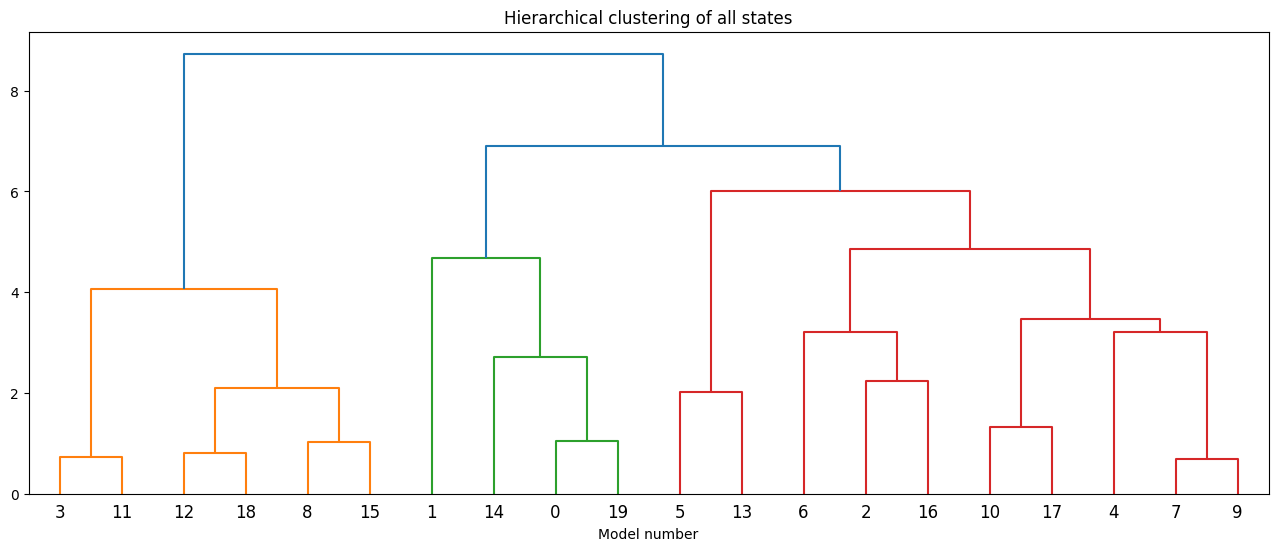

In [18]:
plt.figure(figsize=(16.0, 6.0))
plt.title("Hierarchical clustering of all states")
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel('Model number')
plt.show()

**Now, we select a threshold based on the dendrogram to create a list of clusters for all the structures in the ensemble.**

In [19]:
selected = AgglomerativeClustering(distance_threshold=4.0, n_clusters=None, linkage='ward')
selected = selected.fit(vectors)

In [20]:
labels = selected.labels_
labels

array([4, 5, 1, 6, 0, 3, 1, 0, 2, 0, 0, 6, 2, 3, 4, 2, 1, 0, 2, 4])

**In the final step, we create a PyMol script to directly display the clusters in the protein backbone, coloured by their numbers.**

In [21]:
# Select a pallete for cluster coloring
palette='Dark2'
colors=selected.n_clusters_
pal = sns.color_palette(palette, colors).as_hex()
pal

['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d']

In [22]:
with open('cluster_7qcc.pml', 'w') as f:
    f.write('load 7qcc.pdb, 7qcc\n')
    f.write('split_states 7qcc\n')
    f.write('delete 7qcc\n')
    f.write('color gray40\n')
    for i, label in enumerate(labels):
        color = f'0x{pal[label % colors][1:]}'
        f.write(f'color {color}, 7qcc_{i+1:04d} and resi {ini}-{end}\n')

    f.write(f'sele region, resi {ini}-{end}\n')
    f.write('orient region\n')
    f.write('delete region\n')

**Running this PyMol script will show the selected clustering region and its classification. Remember that this is a brief example, and it will not deal with the complexities of a general clustering algorithm for any protein ensemble. For a far more complete treatment of this problem, please read reference 1.**